# Developing a Classifier for Movie Rating for IMDB Data Set

## Section 0: Load Dependencies and Data

In [366]:
import pandas as pd  # For data manipulation and analysis
from collections import Counter  # For counting hashable objects
from sklearn.decomposition import PCA  # For dimensionality reduction
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For visualization
from sklearn.feature_selection import mutual_info_classif  # For feature importance estimation
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.svm import SVC  # Support Vector Classifier for SVM
from sklearn.model_selection import KFold  # For k-fold cross-validation
import statistics as stat  # For statistical calculations
from sklearn.preprocessing import StandardScaler  # For standardizing features
from sklearn.cross_decomposition import PLSRegression  # Partial Least Squares regression
from sklearn.metrics import r2_score  # For calculating R-squared metric
import random  # For generating random numbers
from sklearn.model_selection import GridSearchCV  # For hyperparameter optimization
import seaborn as sns
from sklearn.model_selection import cross_val_score


# Loading the datasets for training and testing
try:
    Test = pd.read_csv('project_data/test_dataset.csv')  # Test dataset
    Train = pd.read_csv('project_data/train_dataset.csv')  # Training dataset
    print("Datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure the file paths are correct.")
    raise
except pd.errors.EmptyDataError as e:
    print(f"Error: {e}. Ensure the CSV files are not empty.")
    raise
except Exception as e:
    print(f"An unexpected error occurred while loading datasets: {e}")
    raise



# Validating the datasets
def validate_dataset(df, name):
    print(f"\nValidating {name} dataset:")
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("Warning: Missing values detected.")
        print(missing_values[missing_values > 0])
    else:
        print("No missing values detected.")
    
    # Check for duplicate rows
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        print(f"Warning: {duplicate_count} duplicate rows found.")
    else:
        print("No duplicate rows detected.")
    
    # Check for feature consistency
    print("Dataset shape:", df.shape)
    if df.empty:
        print(f"Error: {name} dataset is empty.")
        raise ValueError(f"{name} dataset is empty.")
    elif len(df.columns) == 0:
        print(f"Error: {name} dataset has no columns.")
        raise ValueError(f"{name} dataset has no columns.")
    else:
        print(f"{name} dataset structure is valid.")
    
    # Display basic statistics for numeric columns
    print("Basic statistics:")
    print(df.describe())

# Validate both Train and Test datasets
validate_dataset(Train, "Training")
validate_dataset(Test, "Testing")

print("\nValidation complete.")


Datasets loaded successfully!

Validating Training dataset:
language    1
dtype: int64
No duplicate rows detected.
Dataset shape: (3004, 27)
Training dataset structure is valid.
Basic statistics:
               id  num_critic_for_reviews     duration  \
count  3004.00000             3004.000000  3004.000000   
mean   1502.50000              165.609188   110.076565   
std     867.32443              121.254549    21.910608   
min       1.00000                2.000000    37.000000   
25%     751.75000               76.000000    96.000000   
50%    1502.50000              137.000000   106.000000   
75%    2253.25000              223.000000   120.000000   
max    3004.00000              813.000000   330.000000   

       director_facebook_likes  actor_3_facebook_likes  \
count              3004.000000             3004.000000   
mean                778.890146              767.860186   
std                2990.741946             1901.991202   
min                   0.000000                0.0

## Section 1: Pre-processing, and exploratory analysis

### 1.1: Analyzing Genre Distribution and Frequency

In [367]:
# Split the "genres" column into a list of genres for each movie
Train["genres"] = Train["genres"].apply(lambda x: x.split("|"))

# Initialize an empty list to store all genre occurrences
genreFreqList = []

# Flatten the nested list of genres to prepare for frequency calculation
for genres in Train["genres"]:
    for genre in genres:
        genreFreqList.append(genre)

# Count the occurrences of each genre using Counter
count = Counter(genreFreqList)
print("Genre Frequency Count:", count)  # Output the genre frequency count
print("Number of unique genres:", len(count))  # Output the number of unique genres

# Function to one-hot encode genres for each row
def OneHotEncodeGenre(row):
    """
    Updates the row's genre columns with one-hot encoding.
    Each genre column value is incremented by 1 if the genre is present in the row.

    Parameters:
    row (Series): A row of the DataFrame containing a list of genres.

    Returns:
    Series: Updated row with one-hot encoded genre columns.
    """
    for genre in row["genres"]:  # Iterate over genres in the current row
        row[genre] += 1  # Increment the respective genre column
    return row

# Get the list of unique genres as column labels
labels = list(count.keys())

# Create a DataFrame with one column per genre, initialized to 0
EncodedGenres = pd.DataFrame(0, index=np.arange(len(Train)), columns=labels)

# Copy the "genres" column from the original Train dataset to preserve genre lists
EncodedGenres["genres"] = Train["genres"].copy(deep=True)

print("Initial one-hot encoded DataFrame (before processing):")
print(EncodedGenres)

# Apply the one-hot encoding function to each row of the DataFrame
EncodedGenres = EncodedGenres.apply(lambda x: OneHotEncodeGenre(x), axis=1)

# Drop the now-unnecessary "genres" column as the data has been encoded
EncodedGenres = EncodedGenres.drop(columns=["genres"])

# Output the final one-hot encoded DataFrame
print("Final one-hot encoded DataFrame (after processing):")
print(EncodedGenres)


Genre Frequency Count: Counter({'Drama': 1505, 'Comedy': 1175, 'Thriller': 884, 'Action': 765, 'Romance': 699, 'Adventure': 612, 'Crime': 568, 'Fantasy': 405, 'Sci-Fi': 388, 'Family': 354, 'Horror': 321, 'Mystery': 306, 'Biography': 194, 'Animation': 146, 'War': 127, 'Music': 126, 'History': 125, 'Sport': 114, 'Musical': 79, 'Western': 41, 'Documentary': 37, 'Film-Noir': 1})
Number of unique genres: 22
Initial one-hot encoded DataFrame (before processing):
      Adventure  Animation  Drama  Family  Musical  Horror  Mystery  Sci-Fi  \
0             0          0      0       0        0       0        0       0   
1             0          0      0       0        0       0        0       0   
2             0          0      0       0        0       0        0       0   
3             0          0      0       0        0       0        0       0   
4             0          0      0       0        0       0        0       0   
...         ...        ...    ...     ...      ...     ...      .

### 1.2 Load embeddings

In [368]:
# Load pre-trained embeddings for the dataset
# These embeddings represent specific features in vectorized form for modeling

# Load plot keyword embeddings (Doc2Vec representation)
KWEembeddings = np.load("project_data/features_doc2vec/features_doc2vec/train_doc2vec_features_plot_keywords.npy")

# Load genre embeddings (Doc2Vec representation)
Gembeddings = np.load("project_data/features_doc2vec/features_doc2vec/train_doc2vec_features_genre.npy")

# Load title embeddings (FastText representation)
Tembeddings = np.load("project_data/features_fasttext/features_fasttext/train_fasttext_title_embeddings.npy")

# Convert numpy arrays to pandas DataFrames for easier handling and integration
KeyWordEmbeddings = pd.DataFrame(KWEembeddings)  # DataFrame for plot keyword embeddings
GenreEmbeddings = pd.DataFrame(Gembeddings)  # DataFrame for genre embeddings
TitleEmbeddings = pd.DataFrame(Tembeddings)  # DataFrame for title embeddings

# Display shapes of the embeddings for verification
print("Shape of KeyWordEmbeddings:", KeyWordEmbeddings.shape)
print("Shape of GenreEmbeddings:", GenreEmbeddings.shape)
print("Shape of TitleEmbeddings:", TitleEmbeddings.shape)


Shape of KeyWordEmbeddings: (3004, 100)
Shape of GenreEmbeddings: (3004, 100)
Shape of TitleEmbeddings: (3004, 100)


### 1.3 Content Rating Transformation

In [369]:
from collections import Counter

# Extract content ratings from the dataset
ratings = Train["content_rating"]

# Generate a frequency list of ratings for analysis
ratingsFreqList = [rating for rating in Train["content_rating"]]

# Count the occurrences of each rating
count = Counter(ratingsFreqList)
print("Ratings Frequency Count:", count)

# Define a function to convert content ratings into numerical categories
def convertRatings(row):
    """
    Convert content ratings to numerical categories:
    1 - G, Approved, GP, Passed
    2 - PG, PG-13, or any rating containing '13'
    3 - M, Not Rated, Unrated
    4 - R
    5 - X, NC-17, or similar

    Parameters:
    row (str): The content rating.

    Returns:
    int: The numerical category for the rating.
    """
    # Ensure the input is a string to avoid errors
    row = str(row)

    # Map ratings to categories
    if 'pg' in row.lower() or '13' in row.lower(): 
        return 2
    if row.lower() in ['g', 'gp', 'passed']:
        return 1
    if 'm' in row.lower() or row.lower() in ["not rated", "unrated"]:
        return 3
    if row.lower() == "r":
        return 4
    if row.lower() in ["x", "nc-17"] or "nc" in row.lower():
        return 5
    # Default to category 3 if no specific match
    return 3

# Apply the conversion function to the ratings
ratings = ratings.apply(lambda x: convertRatings(x))

# Print the transformed ratings for validation
print("Transformed Ratings (First 10):")
print(ratings.head(10))


Ratings Frequency Count: Counter({'R': 1362, 'PG-13': 1039, 'PG': 458, 'G': 68, 'Not Rated': 27, 'Unrated': 19, 'Approved': 14, 'X': 9, 'NC-17': 3, 'M': 2, 'Passed': 2, 'GP': 1})
Transformed Ratings (First 10):
0    1
1    4
2    4
3    4
4    2
5    2
6    4
7    3
8    2
9    4
Name: content_rating, dtype: int64


### 1.4 Country Mapping and One-Hot Encoding of Continents

In [370]:
# Get frequencies of countries in the dataset
countryFreqList = [i for i in Train["country"]]
country_count = Counter(countryFreqList)
print("Country Frequency Count:", country_count)

# Prepare a DataFrame to map countries to sub-regions and continents
cont = Train["country"]
sub_region = pd.DataFrame("BLANK", index=np.arange(len(cont)), columns=["sub_region", "continent"])
cont = pd.concat([cont, sub_region], axis=1)

# Load a country-to-region mapping table
countryTable = pd.read_csv("CountryToRegion.csv")

# Function to map countries to their corresponding sub-region and continent
def getRegion(row):
    """
    Maps a country to its sub-region and continent based on the provided mapping table.
    Defaults to 'Northern America' for sub-region and 'Americas' for continent if no match is found.
    """
    val = countryTable.loc[countryTable["country"] == row["country"]]
    if len(val) == 0:
        row["sub_region"] = "Northern America"  # Default sub-region
        row["continent"] = "Americas"  # Default continent
        return row
    # Assign sub-region and continent from the mapping table
    row["sub_region"] = val.iloc[0]["sub_region"]
    row["continent"] = val.iloc[0]["continent"]
    return row

# Apply the region-mapping function to the DataFrame
cont = cont.apply(lambda x: getRegion(x), axis=1)

# Function for one-hot encoding continents
def OneHotEncodeSingleCont(row):
    """
    One-hot encodes a single continent for a given row.
    """
    row[row["continent"]] += 1
    return row

# Get frequencies of continents
continentFreqList = [value for value in cont["continent"]]
continent_count = Counter(continentFreqList)
print("Continent Frequency Count:", continent_count)

# Create a DataFrame for one-hot encoding continents
labels = list(continent_count.keys())  # Get unique continent labels
EncodedCont = pd.DataFrame(0, index=np.arange(len(Train)), columns=labels)  # Initialize one-hot columns
EncodedCont["continent"] = cont["continent"].copy(deep=True)

# Apply one-hot encoding to each row
EncodedCont = EncodedCont.apply(lambda x: OneHotEncodeSingleCont(x), axis=1)

# Drop the original "continent" column as it is no longer needed
EncodedCont = EncodedCont.drop(columns=["continent"])

# Display the one-hot encoded continent DataFrame for verification
print("One-Hot Encoded Continent DataFrame:")
print(EncodedCont.head())


Country Frequency Count: Counter({'USA': 2382, 'UK': 255, 'France': 86, 'Germany': 61, 'Canada': 46, 'Australia': 32, 'Spain': 21, 'Japan': 12, 'New Zealand': 10, 'China': 9, 'Hong Kong': 9, 'Italy': 8, 'South Korea': 7, 'Denmark': 6, 'Mexico': 6, 'Ireland': 6, 'Brazil': 4, 'India': 3, 'Thailand': 3, 'Norway': 3, 'South Africa': 3, 'Netherlands': 3, 'Argentina': 3, 'Iran': 3, 'Hungary': 2, 'Romania': 2, 'Russia': 2, 'Czech Republic': 2, 'Taiwan': 2, 'Chile': 1, 'Afghanistan': 1, 'Israel': 1, 'Colombia': 1, 'West Germany': 1, 'Official site': 1, 'Aruba': 1, 'Finland': 1, 'Iceland': 1, 'Poland': 1, 'Belgium': 1, 'New Line': 1, 'Indonesia': 1})
Continent Frequency Count: Counter({'Americas': 2447, 'Europe': 461, 'Asia': 51, 'Oceania': 42, 'Africa': 3})
One-Hot Encoded Continent DataFrame:
   Americas  Oceania  Europe  Asia  Africa
0         1        0       0     0       0
1         1        0       0     0       0
2         1        0       0     0       0
3         1        0       0   

### 1.5: Combining and Scaling Features

In [371]:
# Define the list of numeric columns to include in the preprocessing pipeline
numericColumnSet = [
    'num_critic_for_reviews', 'duration', 'director_facebook_likes',
    'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
    'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
    'num_user_for_reviews', 'title_year', 'actor_2_facebook_likes',
    'movie_facebook_likes', 'average_degree_centrality'
]

# Combine numeric features, one-hot encoded continents, and transformed ratings into a single DataFrame
PreTotalData = pd.concat([Train[numericColumnSet], EncodedCont, ratings], axis=1)

# Ensure column names are treated as strings to avoid unexpected issues
PreTotalData.columns = PreTotalData.columns.astype(str)

# Create a total dataset by adding Title and Keyword embeddings to the previously defined data
TotalData = pd.concat([Train[numericColumnSet], EncodedCont, ratings, TitleEmbeddings, KeyWordEmbeddings], axis=1)
TotalData.columns = TotalData.columns.astype(str)

# Add Genre embeddings to the total dataset
TotalDataPlusGenreEmbeddings = pd.concat([TotalData, GenreEmbeddings], axis=1)
TotalDataPlusGenreEmbeddings.columns = TotalDataPlusGenreEmbeddings.columns.astype(str)

# Add one-hot encoded genres to the total dataset
TotalDataPlusGenreEncodings = pd.concat([TotalData, EncodedGenres], axis=1)
TotalDataPlusGenreEncodings.columns = TotalDataPlusGenreEncodings.columns.astype(str)

# Initialize a StandardScaler for data standardization
scaler = StandardScaler()

# sclae the 

# Scale the PreTotalData (numeric features, one-hot continents, ratings)
S_TotalData = scaler.fit_transform(PreTotalData)
S_TotalData = pd.DataFrame(S_TotalData, columns=PreTotalData.columns)  # Convert back to DataFrame for clarity

# Scale the TotalDataPlusGenreEmbeddings (includes Genre Embeddings)
scaled_embeddings_data = scaler.fit_transform(TotalDataPlusGenreEmbeddings)
S_TotalDataPlusGenreEmbeddings = pd.DataFrame(scaled_embeddings_data, columns=TotalDataPlusGenreEmbeddings.columns)

# Scale the TotalDataPlusGenreEncodings (includes Genre Encodings)
scaled_encoding_data = scaler.fit_transform(TotalDataPlusGenreEncodings)
S_TotalDataPlusGenreEncoding = pd.DataFrame(scaled_encoding_data, columns=TotalDataPlusGenreEncodings.columns)

# Display shapes of the resulting scaled datasets for verification
print("Shape of S_TotalData:", S_TotalData.shape)
print("Shape of S_TotalDataPlusGenreEncoding:", S_TotalDataPlusGenreEmbeddings.shape)
print("Shape of S_TotalDataPlusGenreEncoding:", S_TotalDataPlusGenreEncoding.shape)


Shape of S_TotalData: (3004, 20)
Shape of S_TotalDataPlusGenreEncoding: (3004, 320)
Shape of S_TotalDataPlusGenreEncoding: (3004, 242)


## Section 2: Feature Engineering and Dimensionality Reduction

### 2.1: Principal Component Analysis (PCA) on Keyword Embeddings

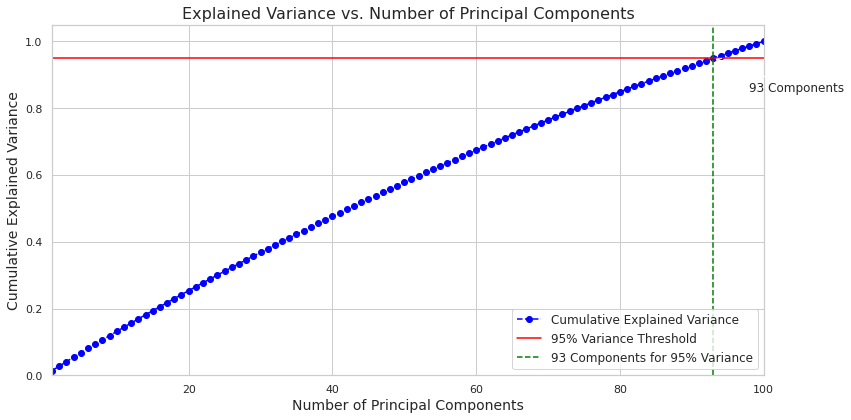

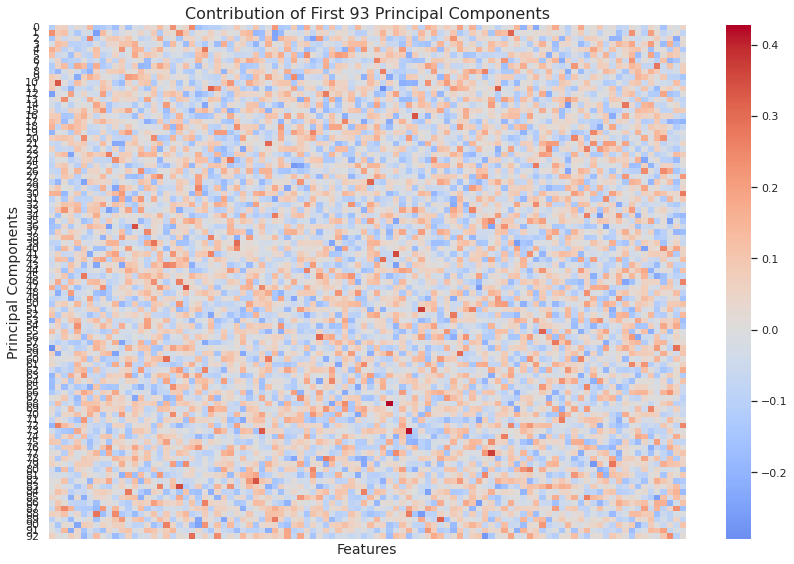

In [372]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

# Perform PCA on the KeyWordEmbeddings
pca = PCA()
pca.fit(KeyWordEmbeddings)  # Fit PCA model on the embeddings

# Extract explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Set up the plot aesthetics using seaborn
sns.set_theme(style="whitegrid")

# Create the figure and axis objects for cumulative variance plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot cumulative variance with markers
ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
        marker='o', linestyle='--', label='Cumulative Explained Variance', color='blue')

# Highlight the point where 95% variance is explained
components_95 = np.argmax(cumulative_variance >= 0.95) + 1
ax.axhline(y=0.95, color='red', linestyle='-', label='95% Variance Threshold')
ax.axvline(x=components_95, color='green', linestyle='--', 
           label=f'{components_95} Components for 95% Variance')

# Add annotations for clarity
ax.annotate(f'{components_95} Components', 
            xy=(components_95, 0.95), 
            xytext=(components_95 + 5, 0.85),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=12)

# Customize the plot
ax.set_title('Explained Variance vs. Number of Principal Components', fontsize=16)
ax.set_xlabel('Number of Principal Components', fontsize=14)
ax.set_ylabel('Cumulative Explained Variance', fontsize=14)
ax.set_xlim(1, len(cumulative_variance))
ax.set_ylim(0.0, 1.05)
ax.legend(loc='lower right', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Heatmap to visualize contribution of principal components
contribution_matrix = pca.components_[:components_95]
plt.figure(figsize=(12, 8))
sns.heatmap(contribution_matrix, cmap='coolwarm', center=0, 
            annot=False, fmt=".2f", xticklabels=False, yticklabels=True)
plt.title(f'Contribution of First {components_95} Principal Components', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Principal Components', fontsize=14)
plt.tight_layout()
plt.show()


### 2.2 Feature Evaluation and PCA on Genre Embeddings

Mutual Information between Title Embeddings and IMDb Score Bins:
[0.         0.00318005 0.00043153 0.00956551 0.00082238 0.01532995
 0.00785553 0.00772514 0.00115445 0.01126045 0.00532958 0.00189026
 0.         0.00855685 0.01946228 0.02647774 0.00465644 0.00343097
 0.00056887 0.00523408 0.03021029 0.01006745 0.00229827 0.
 0.02669065 0.         0.00651661 0.01362896 0.01471979 0.02457737
 0.         0.01879296 0.         0.01683522 0.         0.01686168
 0.0193818  0.         0.01306168 0.01770906 0.01036057 0.01673082
 0.01268001 0.01469227 0.02761664 0.02124814 0.01665444 0.00861722
 0.         0.00786161 0.03214245 0.00512466 0.         0.
 0.01051197 0.00728574 0.0054488  0.00016415 0.01620285 0.01090512
 0.02384988 0.02059718 0.00729989 0.02668568 0.         0.00949239
 0.00611889 0.02166585 0.01433278 0.00737139 0.02039322 0.01016593
 0.01303125 0.01593818 0.02412025 0.00582146 0.         0.01505634
 0.00151585 0.02482412 0.01829345 0.01594238 0.         0.01143285
 0.01301603 0

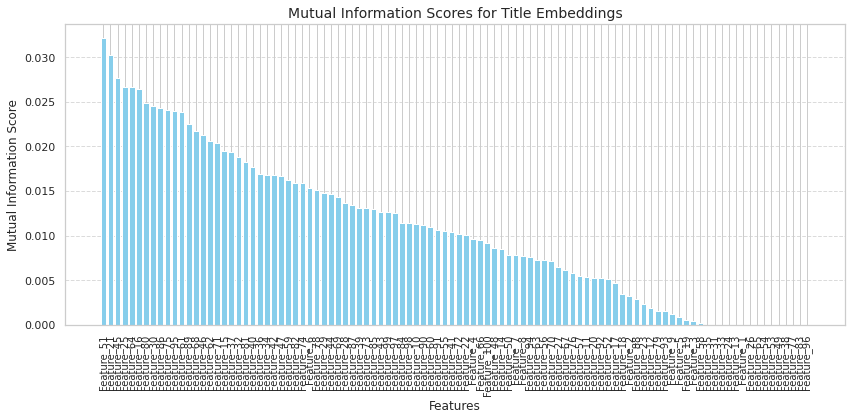





Explained Variance Ratio for Genre Embeddings PCA:
[0.05979388 0.04931599 0.04398562 0.040113   0.03632348 0.03011112
 0.02579819 0.02374498 0.02300882 0.02224901 0.02085838 0.0206749
 0.01838038 0.01752673 0.01725465 0.01649141 0.01550936 0.01492007
 0.01465154 0.0142897  0.01386025 0.01322946 0.01277429 0.01240492
 0.01193996 0.01176254 0.01127166 0.01113133 0.01077045 0.01062245
 0.00993203 0.00989217 0.00935785 0.00932682 0.00912413 0.00890862
 0.00884674 0.00861021 0.00827011 0.00786227 0.0078334  0.00766573
 0.00761226 0.00733602 0.00723136 0.00715692 0.00684287 0.0066426
 0.00645875 0.00627899 0.0061728  0.00610893 0.00602293 0.00579256
 0.00576718 0.00559874 0.00548002 0.00538618 0.00527898 0.00515794
 0.00512157 0.0050098  0.00490471 0.00480279 0.00464384 0.00458996
 0.00456921 0.00448806 0.00440174 0.00425279 0.00419888 0.00402557
 0.00401673 0.00393789 0.00386594 0.00377643 0.00372221 0.00359696
 0.00352352 0.00331599 0.00326344 0.00318361 0.00310899 0.00306072
 0.002983

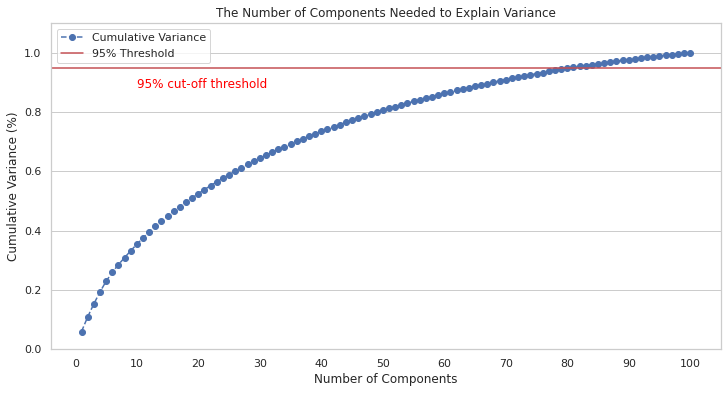

In [373]:
# Evaluate mutual information between title embeddings and binned IMDb scores
print("Mutual Information between Title Embeddings and IMDb Score Bins:")
mi_scores = mutual_info_classif(TitleEmbeddings, Train["imdb_score_binned"])
print(mi_scores)

# Calculate mutual information scores
mi_scores = mutual_info_classif(TitleEmbeddings, Train["imdb_score_binned"])

# Create a DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': [f'Feature_{i+1}' for i in range(len(mi_scores))], 'MI Score': mi_scores})

# Sort the DataFrame by MI scores in descending order for better insights
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

# Plot the mutual information scores as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(mi_df['Feature'], mi_df['MI Score'], color='skyblue')

# Add plot labels and title
plt.xlabel('Features', fontsize=12)
plt.ylabel('Mutual Information Score', fontsize=12)
plt.title('Mutual Information Scores for Title Embeddings', fontsize=14)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

print('\n\n\n')

# Perform PCA on GenreEmbeddings
pca = PCA()
pca.fit(GenreEmbeddings)

# Print the explained variance ratio for PCA
print("Explained Variance Ratio for Genre Embeddings PCA:")
print(pca.explained_variance_ratio_)

# Plot cumulative explained variance for GenreEmbeddings
plt.rcParams["figure.figsize"] = (12, 6)  # Set the figure size

fig, ax = plt.subplots()

# x-axis: Component indices (1-based for human readability)
xi = np.arange(1, len(pca.explained_variance_ratio_) + 1, step=1)

# y-axis: Cumulative sum of explained variance ratios
y = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.ylim(0.0, 1.1)  # Set y-axis range
plt.plot(xi, y, marker='o', linestyle='--', color='b', label='Cumulative Variance')

# Add plot labels and title
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(pca.explained_variance_ratio_) + 1, step=10))  # Adjust step size if needed
plt.ylabel('Cumulative Variance (%)')
plt.title('The Number of Components Needed to Explain Variance')

# Add reference line for the 95% variance threshold
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Threshold')
plt.text(10, 0.88, '95% cut-off threshold', color='red', fontsize=12)

# Add gridlines and legend for clarity
ax.grid(axis='x')
plt.legend()

# Display the plot
plt.show()

### 2.3: Partial Least Squares (PLS) Regression and Component Analysis

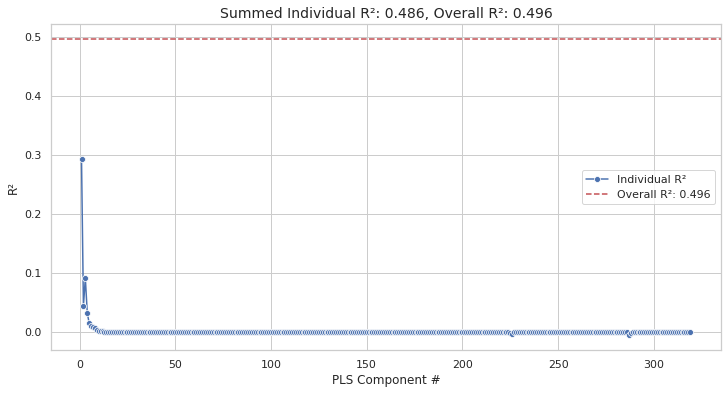

Best number of components: 36, Best R²: 0.349


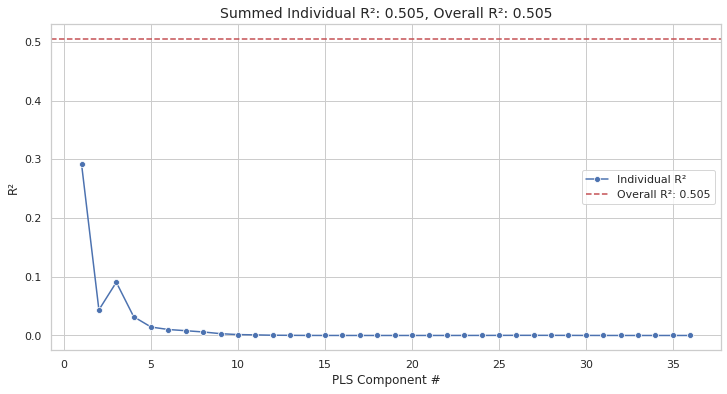

<Figure size 864x432 with 0 Axes>

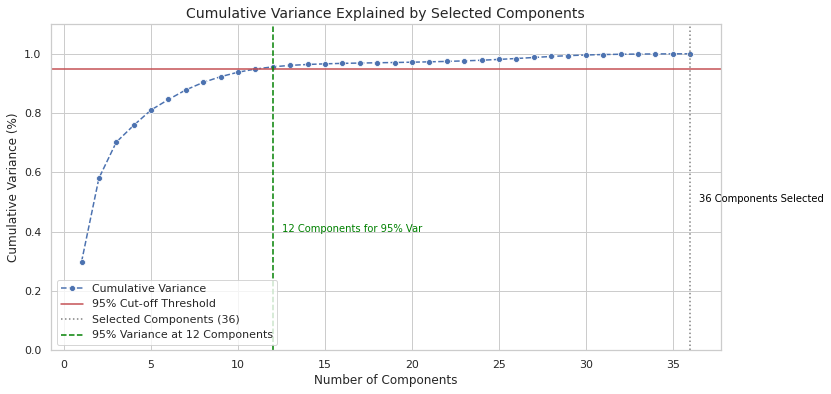

In [374]:
# Standardize the features and target variable
X_scaled = TotalDataPlusGenreEmbeddings
y_scaled = Train["imdb_score_binned"].values.reshape(-1, 1).ravel()

# Fit PLS regression with standardized data
pls = PLSRegression(n_components=len(TotalDataPlusGenreEmbeddings.columns) - 1, max_iter=100000)
pls.fit(X_scaled, y_scaled)

# Evaluate R² for individual components and overall performance
def pls_explained_variance(pls, X, Y_true, do_plot=True):
    r2 = np.zeros(pls.n_components)
    x_transformed = pls.transform(X)
    for i in range(0, pls.n_components):
        Y_pred = (np.dot(x_transformed[:, i][:, np.newaxis],
                         pls.y_loadings_[:, i][:, np.newaxis].T) * pls._y_std
                  + pls._y_mean)
        r2[i] = r2_score(Y_true, Y_pred)
    
    overall_r2 = r2_score(Y_true, pls.predict(X))

    if do_plot:
        import seaborn as sns
        sns.set(style="whitegrid")
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=np.arange(1, pls.n_components + 1), y=r2, marker='o', label='Individual R²')
        plt.axhline(overall_r2, color='r', linestyle='--', label=f'Overall R²: {overall_r2:.3f}')
        plt.xlabel('PLS Component #', fontsize=12)
        plt.ylabel('R²', fontsize=12)
        plt.title(f'Summed Individual R²: {np.sum(r2):.3f}, Overall R²: {overall_r2:.3f}', fontsize=14)
        plt.legend()
        plt.show()

    return r2, overall_r2

# Evaluate and plot explained variance
r2, overall_r2 = pls_explained_variance(pls, X_scaled, y_scaled, do_plot=True)

# Find the optimal number of PLS components using cross-validation
best_r2 = float('-inf')
best_n_components = 0

for n in range(1, 100):  # Test components from 1 to 20
    pls = PLSRegression(n_components=n)
    scores = cross_val_score(pls, X_scaled, y_scaled, cv=5, scoring='r2')
    mean_r2 = np.mean(scores)
    # print(f"Components: {n}, Mean R²: {mean_r2:.3f}")
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_n_components = n

print(f"Best number of components: {best_n_components}, Best R²: {best_r2:.3f}")

# Fit PLS with the optimal number of components
pls = PLSRegression(n_components=best_n_components)
pls.fit(X_scaled, y_scaled)
r2, overall_r2 = pls_explained_variance(pls, X_scaled, y_scaled, do_plot=True)


# Calculate cumulative variance for selected components
PLScomponents = pls.transform(X_scaled)
tempList = []
for i in range(1, best_n_components + 1):
    Itemp = PLScomponents[:, i - 1]
    Jtemp = y_scaled
    tempList.append(np.abs(np.cov(Itemp, Jtemp)[1, 0]))

# Plot cumulative variance explained by components
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
xi = np.arange(1, best_n_components + 1, step=1)
y = np.cumsum(tempList) / sum(tempList)

# Calculate cumulative variance for selected components
PLScomponents = pls.transform(X_scaled)
tempList = []
for i in range(1, best_n_components + 1):
    Itemp = PLScomponents[:, i - 1]
    Jtemp = y_scaled
    tempList.append(np.abs(np.cov(Itemp, Jtemp)[1, 0]))

# Plot cumulative variance explained by components
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
xi = np.arange(1, best_n_components + 1, step=1)
y = np.cumsum(tempList) / sum(tempList)

# ─────────────────────────────────────────────────────────────────────────────
# 1. DETERMINE HOW MANY COMPONENTS ARE NEEDED FOR 95% CUMULATIVE VARIANCE
#    np.argmax(...) returns the FIRST index where condition is met
#    +1 because Python indexing starts at 0.
# ─────────────────────────────────────────────────────────────────────────────
n_comp_95 = np.argmax(y >= 0.95) + 1

# Existing plot code
sns.lineplot(x=xi, y=y, marker='o', linestyle='--', color='b', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Cut-off Threshold')

# Existing vertical line/text for best_n_components
plt.vlines(best_n_components, 0, 1.2, linestyles='dotted', colors='gray', 
           label=f'Selected Components ({best_n_components})')
plt.text(best_n_components + 0.5, 0.5, f'{best_n_components} Components Selected', 
         color='black', fontsize=10)

# ─────────────────────────────────────────────────────────────────────────────
# 2. ADD A NEW VERTICAL LINE AND TEXT FOR n_comp_95
# ─────────────────────────────────────────────────────────────────────────────
plt.vlines(n_comp_95, 0, 1.2, linestyles='--', colors='green',
           label=f'95% Variance at {n_comp_95} Components')
plt.text(n_comp_95 + 0.5, 0.4, f'{n_comp_95} Components for 95% Var',
         color='green', fontsize=10)

plt.ylim(0.0, 1.1)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Variance (%)', fontsize=12)
plt.title('Cumulative Variance Explained by Selected Components', fontsize=14)
plt.legend()
plt.show()


# Section 3: Model Selection and Performance Evaluation

### 3.1 Model Evaluation with Cross-Validation and Feature Scaling

In [375]:
# Function to evaluate models on multiple datasets with cross-validation
def evaluate_models(datasets, models, k_splits=5):
    """
    Evaluate multiple models on multiple datasets using K-Fold cross-validation.

    Parameters:
    - datasets: List of datasets to evaluate.
    - models: List of models (as tuples: (name, model)) to evaluate.
    - k_splits: Number of splits for K-Fold cross-validation.

    Returns:
    - None (prints evaluation results for each dataset and model).
    """
    kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)  # Shuffle for randomness

    for dataset in datasets:
        print(f"\nEvaluating Dataset: {dataset.name}")
        for model_name, model in models:
            avg_scores = []  # Store accuracy scores for each fold
            std_scores = []  # Track standard deviations
            for train_index, test_index in kf.split(dataset.data):
                # Split data into train and test sets
                X_train, X_test = dataset.data.iloc[train_index], dataset.data.iloc[test_index]
                Y_train, Y_test = Train.iloc[train_index]["imdb_score_binned"], Train.iloc[test_index]["imdb_score_binned"]

                # Train the model and calculate accuracy
                model.fit(X_train, Y_train)
                accuracy = model.score(X_test, Y_test)
                avg_scores.append(accuracy)

            # Calculate mean and standard deviation of accuracy
            mean_score = stat.mean(avg_scores)
            std_score = stat.stdev(avg_scores)

            # Print results
            print(f"  Model: {model_name}")
            print(f"    Average Accuracy: {mean_score:.4f}")
            print(f"    Standard Deviation: {std_score:.4f}")


# Define datasets to evaluate
class DatasetWrapper:
    def __init__(self, name, data):
        self.name = name
        self.data = data

datasets = [
    DatasetWrapper("TotalData", TotalData),
    DatasetWrapper("TotalDataPlusGenreEncodings", TotalDataPlusGenreEncodings),
    DatasetWrapper("TotalDataPlusGenreEmbeddings", TotalDataPlusGenreEmbeddings)
]

# Define models to evaluate
models = [
    ("Logistic Regression", LogisticRegression(max_iter=100000)),
    ("Support Vector Classifier (SVC)", SVC())
]

# Run the evaluation
evaluate_models(datasets, models, k_splits=5)



Evaluating Dataset: TotalData


/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

  Model: Logistic Regression
    Average Accuracy: 0.6718
    Standard Deviation: 0.0249
  Model: Support Vector Classifier (SVC)
    Average Accuracy: 0.6168
    Standard Deviation: 0.0255

Evaluating Dataset: TotalDataPlusGenreEncodings


/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

  Model: Logistic Regression
    Average Accuracy: 0.6754
    Standard Deviation: 0.0179
  Model: Support Vector Classifier (SVC)
    Average Accuracy: 0.6168
    Standard Deviation: 0.0255

Evaluating Dataset: TotalDataPlusGenreEmbeddings


/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

  Model: Logistic Regression
    Average Accuracy: 0.6774
    Standard Deviation: 0.0257
  Model: Support Vector Classifier (SVC)
    Average Accuracy: 0.6168
    Standard Deviation: 0.0255


### 1.9 feature selection using ablation approach

In [376]:
def accuracy_SVM(X,Y,Xt,Yt):
    clf = SVC()
    clf.fit(X,Y)
    return clf.score(Xt,Yt)

def accuracy_Logistic(X,Y,Xt,Yt):
    clf = LogisticRegression(max_iter=100000,random_state=1273213)
    clf.fit(X,Y)
    return clf.score(Xt,Yt)

def AIC_Logistic(X,Y,Xt,Yt):
    clf = LogisticRegression(max_iter=100000,random_state=1273213)
    clf.fit(X,Y)
    return 2*len(X) - 2*clf.predict_log_proba(Xt)

random.seed = 10023913
### pass entire data set
### test FULL model, get AIC
### remove each column and score model, get AIC score for each removal
### get lowest AIC score, remove column
### repeat until no features have positive AIC score
### generalise for AIC, Accuracy, and BIC

def ablationFeatureSelection(fullDataSet,TestSet,scoreFunc,MaxOrMin,nSplits,threshold = False):
    featureDict = {} #store the score for each removed feature
    columnIndex = {} #index for each column
    iter = 0
    kf = KFold(n_splits=nSplits,random_state=10201331,shuffle=True) 
    for series_name, series in fullDataSet.items():
        columnIndex[iter] = series_name
        iter += 1


    avgScr = []
    for j, (train_index, test_index) in enumerate(kf.split(fullDataSet)):
        X = fullDataSet.iloc[train_index]
        Y = TestSet.iloc[train_index]
        Xt = fullDataSet.iloc[test_index]
        Yt = TestSet.iloc[test_index]
        avgScr.append(scoreFunc(X,Y,Xt,Yt))
    print("baseline:", stat.mean(avgScr))

    ###iterate over feature set
    for i in range(fullDataSet.shape[1]):
        targetFeatureName = columnIndex[i]
        FeatureSet = fullDataSet.drop(columns=[targetFeatureName],axis=1)
        avgScr = []
        for j, (train_index, test_index) in enumerate(kf.split(FeatureSet)):
            X = FeatureSet.iloc[train_index]
            Y = TestSet.iloc[train_index]
            Xt = FeatureSet.iloc[test_index]
            Yt = TestSet.iloc[test_index]

            avgScr.append(scoreFunc(X,Y,Xt,Yt))
        featureDict[targetFeatureName] = stat.mean(avgScr)

    #get either the lowest or highest outcome or maybe outcomes
    if (MaxOrMin == 'maxamise'):
        maxval = max(featureDict.values())
        badColumns = list(filter(lambda x: featureDict[x]==maxval, featureDict))
    else:
        minval = min(featureDict.values())
        badColumns = list(filter(lambda x: featureDict[x]==minval, featureDict))
    
    return random.choice(badColumns), featureDict[random.choice(badColumns)]

### curr feature set goes in
###
###

def buildUp(currFeatureSet,fullDataSet,TestSet,scoreFunc,MaxOrMin,nSplits,threshold = False):
    featureDict = {} #store the score for each removed feature
    columnIndex = {} #index for each column
    iter = 0
    kf = KFold(n_splits=nSplits,random_state=10201331,shuffle=True) 
    for series_name, series in fullDataSet.items():
        columnIndex[iter] = series_name
        iter += 1

    for i in range(fullDataSet.shape[1]-len(currFeatureSet)):
        targetFeatureName = columnIndex[i]
        if (targetFeatureName in currFeatureSet):
            break
        combo = currFeatureSet + [targetFeatureName]
        FeatureSet = fullDataSet[combo]
        avgScr = []
        for j, (train_index, test_index) in enumerate(kf.split(FeatureSet)):
            X = FeatureSet.iloc[train_index]
            Y = TestSet.iloc[train_index]
            Xt = FeatureSet.iloc[test_index]
            Yt = TestSet.iloc[test_index]

            avgScr.append(scoreFunc(X,Y,Xt,Yt))
        featureDict[targetFeatureName] = stat.mean(avgScr)

    if (MaxOrMin == 'maxamise'):
        maxval = max(featureDict.values())
        badColumns = list(filter(lambda x: featureDict[x]==maxval, featureDict))
    else:
        minval = min(featureDict.values())
        badColumns = list(filter(lambda x: featureDict[x]==minval, featureDict))
    
    return random.choice(badColumns), featureDict[random.choice(badColumns)]



ablationAttempt = S_TotalDataPlusGenreEncoding.copy(deep=True)
currFeat = []
baseLineAccuracy = 0
while (1):
    columnName, accuracy = buildUp(currFeat, ablationAttempt,Train["imdb_score_binned"],accuracy_Logistic,'maxamise',25)
    if (accuracy < baseLineAccuracy):
        break
    print(columnName, " , ", accuracy)
    currFeat.append(columnName)
    print("current combo: ",currFeat)
    baseLineAccuracy = accuracy

'''
while len(ablationAttempt.columns) > 1:
    print(len(ablationAttempt.columns))
    columnName,accuracy = ablationFeatureSelection(ablationAttempt, Train["imdb_score_binned"],accuracy_Logistic,'maxamise',2,)
    if (accuracy < baseline):
        break
    print(columnName, " , ", accuracy)
    ablationAttempt.drop(columns=[columnName],inplace=True,axis=1)
    baseline = accuracy
'''




num_voted_users  ,  0.6617796143250688
current combo:  ['num_voted_users']
gross  ,  0.6787630853994491
current combo:  ['num_voted_users', 'gross']


'\nwhile len(ablationAttempt.columns) > 1:\n    print(len(ablationAttempt.columns))\n    columnName,accuracy = ablationFeatureSelection(ablationAttempt, Train["imdb_score_binned"],accuracy_Logistic,\'maxamise\',2,)\n    if (accuracy < baseline):\n        break\n    print(columnName, " , ", accuracy)\n    ablationAttempt.drop(columns=[columnName],inplace=True,axis=1)\n    baseline = accuracy\n'

### 2.1 Model on PLS outcome

In [377]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
kf = KFold(n_splits=20,random_state=10201331,shuffle=True) 

avgScr = []
for j, (train_index, test_index) in enumerate(kf.split(PLScomponents)):
    X = PLScomponents[train_index,0:11]
    Y = Train["imdb_score_binned"].iloc[train_index]
    Xt = PLScomponents[test_index,0:11]
    Yt = Train["imdb_score_binned"].iloc[test_index]
    clf = LogisticRegression(max_iter=100000)
    clf.fit(X,Y)
    avgScr.append(clf.score(Xt,Yt))
print(stat.mean(avgScr))

0.7227019867549669


### 2.2 Grid search over

In [378]:


params = [{'max_depth': range(20,100,20),'n_estimators':range(50,500,75),'criterion':[ "gini", "entropy", "log_loss"]} ]

RF = RandomForestClassifier(random_state=10000)

gs_RandomForest = GridSearchCV(RF,
                               param_grid=params,
                               scoring='accuracy',
                               cv=4,
                               verbose=3)
gs_RandomForest.fit(S_TotalData, Train["imdb_score_binned"])
print(gs_RandomForest.best_params_, gs_RandomForest.best_score_)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[CV 1/4] END criterion=gini, max_depth=20, n_estimators=50;, score=0.716 total time=   0.1s
[CV 2/4] END criterion=gini, max_depth=20, n_estimators=50;, score=0.719 total time=   0.2s
[CV 3/4] END criterion=gini, max_depth=20, n_estimators=50;, score=0.715 total time=   0.1s
[CV 4/4] END criterion=gini, max_depth=20, n_estimators=50;, score=0.728 total time=   0.2s
[CV 1/4] END criterion=gini, max_depth=20, n_estimators=125;, score=0.716 total time=   0.4s
[CV 2/4] END criterion=gini, max_depth=20, n_estimators=125;, score=0.727 total time=   0.4s
[CV 3/4] END criterion=gini, max_depth=20, n_estimators=125;, score=0.719 total time=   0.4s
[CV 4/4] END criterion=gini, max_depth=20, n_estimators=125;, score=0.724 total time=   0.4s
[CV 1/4] END criterion=gini, max_depth=20, n_estimators=200;, score=0.715 total time=   0.6s
[CV 2/4] END criterion=gini, max_depth=20, n_estimators=200;, score=0.724 total time=   0.6s
[CV 3/4] END

### 2.3 grid search over entire non-pls dataset

In [ ]:
params = [{'max_depth': [25,50,75,100],'n_estimators':[100,300,500],'criterion':[ "gini", "entropy"]} ]

RF = RandomForestClassifier(random_state=10000)

gs_RandomForest = GridSearchCV(RF,
                               param_grid=params,
                               scoring='accuracy',
                               cv=3,
                               verbose=3)
gs_RandomForest.fit(S_TotalDataPlusGenreEncoding, Train["imdb_score_binned"])
print(gs_RandomForest.best_params_, gs_RandomForest.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END criterion=gini, max_depth=25, n_estimators=100;, score=0.660 total time=   1.6s
[CV 2/3] END criterion=gini, max_depth=25, n_estimators=100;, score=0.663 total time=   1.6s
[CV 3/3] END criterion=gini, max_depth=25, n_estimators=100;, score=0.678 total time=   1.6s
[CV 1/3] END criterion=gini, max_depth=25, n_estimators=300;, score=0.665 total time=   4.7s
[CV 2/3] END criterion=gini, max_depth=25, n_estimators=300;, score=0.660 total time=   5.5s
[CV 3/3] END criterion=gini, max_depth=25, n_estimators=300;, score=0.681 total time=   4.8s
[CV 1/3] END criterion=gini, max_depth=25, n_estimators=500;, score=0.668 total time=   7.8s
[CV 2/3] END criterion=gini, max_depth=25, n_estimators=500;, score=0.666 total time=   7.7s
[CV 3/3] END criterion=gini, max_depth=25, n_estimators=500;, score=0.679 total time=   8.0s
[CV 1/3] END criterion=gini, max_depth=50, n_estimators=100;, score=0.659 total time=   1.6s
[CV 2/3] 

### neural network

In [ ]:

import sys
print (sys.path)
sys.path.append("/Users/HAWal/AppData/Roaming/Python/Python311/Scripts")
print (sys.path)

import torch
import torch.nn.functional as F
import torch.utils.data as dataUtils

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from collections import Counter

import matplotlib.pyplot as plt

import time


class NeuralNetwork(torch.nn.Module):
    def __init__(self, nInputs, l1, l2, l3, nClasses):
        super(NeuralNetwork, self).__init__()
        self.Numerical = torch.nn.Sequential(
            torch.nn.Linear(20, 10),
            torch.nn.Sigmoid(),
            torch.nn.Linear(10,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Embeddings1 = torch.nn.Sequential(
            torch.nn.Linear(100, 20),
            torch.nn.Sigmoid(),
            torch.nn.Linear(20,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Embeddings2 = torch.nn.Sequential(
            torch.nn.Linear(100,20),
            torch.nn.Sigmoid(),
            torch.nn.Linear(20,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Embeddings3 = torch.nn.Sequential(
            torch.nn.Linear(100,20),
            torch.nn.Sigmoid(),
            torch.nn.Linear(20,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Combination = torch.nn.Sequential(
            torch.nn.Linear(40,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25),
            torch.nn.Linear(10,nClasses),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        a = self.Numerical(x[:,0:20])
        b = self.Embeddings1(x[:,20:120])
        c = self.Embeddings2(x[:,120:220])
        d = self.Embeddings3(x[:,220:320])
        combined = torch.cat((a,b,c,d), dim=1)
        out = self.Combination(combined)
        return out

def test(model, criterion, test_loader):
    test_loss = 0.
    test_preds, test_labels = list(), list()
    for i, data in enumerate(test_loader):
        x, labels = data

        with torch.no_grad():
            logits = model(x)
            predictions = torch.argmax(logits, dim=1)
            test_loss += criterion(input=logits, target=labels).item()
            test_preds.append(predictions)
            test_labels.append(labels)

    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)

    test_accuracy = torch.eq(test_preds, test_labels).float().mean().item()

    print('[TEST] Mean loss {:.4f} | Accuracy {:.4f}'.format(test_loss/len(test_loader), test_accuracy))


def train(model, train_loader, test_loader, optimizer, n_epochs=10):
    LOG_INTERVAL = 250
    running_loss, running_accuracy = list(), list()
    start_time = time.time()
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(n_epochs):

        epoch_loss = 0.

        for i, data in enumerate(train_loader):

            x, labels = data

            logits = model(x)

            predictions = torch.argmax(logits, dim=1)
            train_acc = torch.mean(torch.eq(predictions, labels).float()).item()

            loss = criterion(input=logits, target=labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_loss.append(loss.item())
            running_accuracy.append(train_acc)

            epoch_loss += loss.item()

            if i % LOG_INTERVAL == 0:
                deltaT = time.time() - start_time
                mean_loss = epoch_loss / (i+1)
                print('[TRAIN] Epoch {} [{}/{}]| Mean loss {:.4f} | Train accuracy {:.5f} | Time {:.2f} s'.format(epoch, 
                    i, len(train_loader), mean_loss, train_acc, deltaT))

        print('Epoch complete! Mean loss: {:.4f}'.format(epoch_loss/len(train_loader)))

        test(model, criterion, test_loader)
    return running_loss, running_accuracy


xTrain, xTest, yTrain, yTest = train_test_split(TotalDataPlusGenreEmbeddings, Train["imdb_score_binned"], test_size=0.2, random_state=981488)

xTrain = torch.tensor(xTrain.values, dtype=torch.float)
yTrain = torch.tensor(yTrain.values).type(torch.LongTensor)
trainData = dataUtils.TensorDataset(xTrain, yTrain)
trainLoader = dataUtils.DataLoader(trainData, batch_size=128, shuffle=True)

xTest = torch.tensor(xTest.values, dtype=torch.float)
yTest = torch.tensor(yTest.values).type(torch.LongTensor)
testData = dataUtils.TensorDataset(xTest, yTest)
testLoader = dataUtils.DataLoader(testData, batch_size=128, shuffle=False)

neuralNetwork = NeuralNetwork(len(TotalDataPlusGenreEmbeddings.columns), 150, 100, 50, 5)

optimizer = torch.optim.SGD(neuralNetwork.parameters(), lr=1e-2, momentum=0.5)

nnLoss, nnAcc = train(neuralNetwork, trainLoader, testLoader, optimizer, 100)

plt.plot(nnLoss)
plt.xlabel("iterations")
plt.ylabel("Cross-entropy Loss (Train)")
plt.show()

plt.plot(nnAcc)
plt.xlabel("iterations")
plt.ylabel("Accuracy (Train)")
plt.show()